# Comparative analysis for volumetric versus surface-based source reconstruction

In [2]:
from mne.externals.pymatreader import read_mat
import seaborn as sns
from mne.transforms import apply_trans
import numpy as np
import nibabel as nib
import matplotlib.pylab as plt
import pandas as pd
from scipy.spatial import KDTree
from nibabel.freesurfer.io import read_geometry, write_geometry
import trimesh
import matplotlib as mpl
import matplotlib.cm as cm
import open3d
from pathlib import Path
from mne import create_info
import mne
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from glob import glob

def plot_values_topomap(value_dict, montage, axes, colorbar=True, cmap='RdBu_r', vmin=None, vmax=None):
    ch_names = list(value_dict.keys())
    info = create_info(ch_names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(ch_names), 1)), info, copy=None, verbose=False).set_montage(montage)
    
        
    im = plot_topomap(list(value_dict.values()), pos=info, show=False, #image_interp='bilinear',
                     sensors=True, axes=axes, names=info.ch_names, show_names=False,
                     vmin=vmin, vmax=vmax, extrapolate="head")
    if colorbar:
        cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                  format='%3.2f')
        cbar.ax.tick_params(labelsize=12)
        #cbar.set_ticks((vmin_, vmax_))    
    
    return im

# MATLAB side of things - Computing sources for volume- and surface-based head models

### Some code for MATLAB integration

In [18]:
import matlab.engine
import io
from IPython.core.magic import register_cell_magic
ip = get_ipython()

out = io.StringIO()
err = io.StringIO()

# Setup matlab cell magic #
@register_cell_magic
def matlab_magic(line,cell):
    out.truncate(0)
    out.seek(0)
    err.truncate(0)
    err.truncate(0)
    raw = '''{line}.eval("""{cell}""", nargout=0, stdout=out, stderr=err)'''
    ip.run_cell(raw.format(line=line, cell=cell))
    print(out.getvalue())
    print(err.getvalue())

eng = matlab.engine.start_matlab()

### Saving clean ERP data

In [19]:
%%matlab_magic eng

close all
clear all

subjects = {'602'};

for nosubject=1:length(subjects)
    subject = subjects{nosubject};
    
    file = ['/media/christian/seagate/eegip/london/derivatives/lossless/sub-s' ...
                subject '/ses-m06/eeg/sub-s' subject '_ses-m06_eeg_qcr.set'];

    EEG = pop_loadset('filename', file);
    EEG = eeg_checkset(EEG);
    %purge all channels, time, and components that were flagged...
    EEG = pop_marks_select_data(EEG, 'channel marks',[],'labels',{'manual', 'rank'}, 'remove','on');
    EEG = pop_marks_select_data(EEG, 'time marks', [], 'labels', {'manual'}, 'remove', 'on');
    EEG = pop_marks_select_data(EEG, 'component marks', [], 'labels', {'manual'}, 'remove', 'on');


    filename = ['sub-s' subject '_ses-m06_eeg_cleaned.set'];
    pop_saveset(EEG, 'filename', filename);

    cfg                         = [];
    cfg.dataset                 = filename;
    cfg.trialfun                = 'ft_trialfun_general'; % this is the default
    cfg.trialdef.eventtype      = 'trigger';
    cfg.trialdef.prestim        = 0.2; % in seconds
    cfg.trialdef.poststim       = 0.8; % in seconds

    cfg.trialdef.eventvalue     = {'Nois'};
    cfg_noise = ft_definetrial(cfg);

    cfg.trialdef.eventvalue     = {'dyn1', 'dyn2', 'dyn3', 'dynO', 'sta1', 'sta2', 'sta3'};
    cfg_faces = ft_definetrial(cfg);


    %% Dealing with discontinuities
    starts = [];
    ends = [];
    for noevent=1:length(cfg_noise.event)
        if strcmp(cfg_noise.event(noevent).value, 'boundary')
            starts = [starts; cfg_noise.event(noevent).sample];
            ends = [ends; cfg_noise.event(noevent).sample + 1];
            %ends = [ends; cfg_noise.event(noevent).sample + cfg_noise.event(noevent).duration];
        end
    end
    cfg_noise.artfctdef.reject          = 'complete';
    cfg_noise.artfctdef.jump.artifact   = [starts ends];
    cfg_noise = ft_rejectartifact(cfg_noise);
    
    
    starts = [];
    ends = [];
    for noevent=1:length(cfg_faces.event)
        if strcmp(cfg_faces.event(noevent).value, 'boundary')
            starts = [starts; cfg_faces.event(noevent).sample];
            ends = [ends; cfg_faces.event(noevent).sample + 1];
            %ends = [ends; cfg_noise.event(noevent).sample + cfg_noise.event(noevent).duration];
        end
    end    
    cfg_faces.artfctdef.reject          = 'complete';
    cfg_faces.artfctdef.jump.artifact   = [starts ends];
    cfg_faces = ft_rejectartifact(cfg_faces);      
    

    %cfg_noise.demean          = 'no';
    cfg_noise.lpfilter        = 'no';     
    cfg_noise.demean          = 'yes';
    cfg_noise.baselinewindow  = [-0.2 0];
    %cfg_noise.lpfilter        = 'yes'; 
    %cfg_noise.lpfreq          = 35.0;
    data_noise = ft_preprocessing(cfg_noise);



    %cfg_noise.demean          = 'no';
    cfg_noise.lpfilter        = 'no';     
    cfg_faces.demean          = 'yes';
    cfg_faces.baselinewindow  = [-0.2 0];
    %cfg_faces.lpfilter        = 'yes';  
    %cfg_faces.lpfreq          = 35.0;   
    data_faces = ft_preprocessing(cfg_faces);


    selchan = ft_channelselection({'all' '-Cz'}, data_faces.label);
    cfg = [];
    cfg.channel = selchan;

    data_noise = ft_selectdata(cfg, data_noise);
    data_faces = ft_selectdata(cfg, data_faces);


    %% ERP
    cfg = [];
    cfg.covariance = 'yes';
    cfg.covariancewindow = [-0.2 0]; %it will calculate the covariance matrix
                                   % on the timepoints that are
                                   % before the zero-time point in the trials
    cfg.keeptrials = 'yes';

    tlck_noise = ft_timelockanalysis(cfg, data_noise);
    tlck_faces = ft_timelockanalysis(cfg, data_faces);

    save(['tlck_' subject '_noise.mat'], 'tlck_noise');
    save(['tlck_' subject '_faces.mat'], 'tlck_faces');
end

pop_loadset(): loading file /media/christian/seagate/eegip/london/derivatives/lossless/sub-s602/ses-m06/eeg/sub-s602_ses-m06_eeg_qcr.set ...
Reading float file '/media/christian/seagate/eegip/london/derivatives/lossless/sub-s602/ses-m06/eeg/sub-s602_ses-m06_eeg_qcr.fdt'...
INFO:	2020-10-20T18:50:53	0.022895	0.007894	eeg_checkset:999:	Scaling components to RMS microvolt

INFO:	2020-10-20T18:50:53	0.241302	0.214320	eeg_checkset:999:	Scaling components to RMS microvolt

Removing 22 channel(s)...
INFO:	2020-10-20T18:50:54	0.788691	0.543082	eeg_checkset:999:	Scaling components to RMS microvolt

INFO:	2020-10-20T18:50:54	0.880074	0.088824	eeg_checkset:594:	Event resorted by increasing latencies.

INFO:	2020-10-20T18:50:54	0.912055	0.014829	eeg_checkset:999:	Scaling components to RMS microvolt

eeg_insertbound(): 24 boundary (break) events added.
eeg_insertbound(): event latencies recomputed and 274 events removed.
INFO:	2020-10-20T18:50:54	1.370813	0.456713	eeg_checkset:999:	Scaling componen

### Compute head model - BEM

In [ ]:
%%matlab_magic eng

clear all
close all

template_models = {'12-0Months'};
for no_template=1:length(template_models)

    %% Load and indexed segmentation (BEM)
    root = '/media/christian/ElementsSE/Richards/Infants/Sources/';
    atlas = ft_read_atlas([root 'BEM/AVG' template_models{no_template} ... 
                           '3T_segmented_BEM5.nii.gz']);

    % Removing the "bounding-box" artifact
    atlas.parcellation(1, :, :) = 0;
    atlas.parcellation(:, 1, :) = 0;
    atlas.parcellation(:, :, 1) = 0;
    atlas.parcellation(atlas.dim(1), :, :) = 0;
    atlas.parcellation(:, atlas.dim(2), :) = 0;
    atlas.parcellation(:, :, atlas.dim(3)) = 0;
    atlas.parcellationlabel={'white', 'gray', 'csf', 'skull','scalp'};

    cfg = [];
    cfg.method = 'nearest';
    resliced_atlas = ft_volumereslice(cfg, atlas);

    nan_inds = isnan(resliced_atlas.parcellation);
    resliced_atlas.parcellation(nan_inds) = 0;

    segmentation = struct();
    segmentation.seglabel = transpose(atlas.parcellationlabel);
    segmentation.seg = resliced_atlas.parcellation;
    segmentation.dim = resliced_atlas.dim;
    segmentation.transform = resliced_atlas.transform;
    segmentation.unit = resliced_atlas.unit;
    segmentation.coordsys = resliced_atlas.coordsys;

    
    %% Prepare BEM head model
    cfg=[];
    cfg.tissue={'brain','skull','scalp'};
    cfg.numvertices = [3000 3000 3000];
    bnd=ft_prepare_mesh(cfg,segmentation);

    
    %% Prepare head model
    cfg        = [];
    cfg.method ='dipoli'; 
    cfg.conductivity = [0.3300 0.0041 0.3300];
    headmodel        = ft_prepare_headmodel(cfg, bnd);


    %% Reading electrode positions
    elec = ft_read_sens([root 'Electrodes/AVG' template_models{no_template} ...
                         '3T_HGSN128_electrodes.txt'], ...
                        'senstype', 'eeg', 'fileformat', '4d_el_ascii');
    elec.label = elec.fid.label(2:end);
    elec.elecpos = elec.fid.pnt(2:end, :);
    elec.chanpos = elec.fid.pnt(2:end, :);


    %% Create a source model
    segmentation.inside = segmentation.seg == 2; % Inside the grey matter
    cfg            = [];
    cfg.mri        = segmentation;
    cfg.threshold  = 0;
    cfg.resolution = 6;
    cfg.smooth     = 1;
    cfg.unit       = 'mm';   
    sourcemodel    = ft_prepare_sourcemodel(cfg);
    sourcemodel.pos = sourcemodel.pos(sourcemodel.inside, :)
    sourcemodel.inside = sourcemodel.inside(sourcemodel.inside)
    
    %% Forward modeling
    cfg = [];
    cfg.sourcemodel = sourcemodel;    %% where are the sources?
    cfg.headmodel   = headmodel;      %% how do currents spread?
    cfg.elec        = elec; %% where are the sensors?
    leadfield = ft_prepare_leadfield(cfg);

    
    save(['headmodel_bem_' template_models{no_template} '.mat'], 'headmodel');
    save(['leadfield_bem_' template_models{no_template} '.mat'], 'leadfield');
end



### Compute head model - FEM

In [ ]:
%%matlab_magic eng

clear all
close all

template_models = {'12-0Months'};
for no_template=1:length(template_models)
    %% Load and indexed segmentation (FEM)
    root = '/media/christian/ElementsSE/Richards/Infants/Sources/';
    atlas = ft_read_atlas([root 'FEM/AVG' template_models{no_template} ...
                           '3T_segmented_FEM.nii.gz']);

    %% Removing the "bounding-box" artifact
    atlas.parcellation(1, :, :) = 0;
    atlas.parcellation(:, 1, :) = 0;
    atlas.parcellation(:, :, 1) = 0;
    atlas.parcellation(atlas.dim(1), :, :) = 0;
    atlas.parcellation(:, atlas.dim(2), :) = 0;
    atlas.parcellation(:, :, atlas.dim(3)) = 0;

    cfg = [];
    cfg.method = 'nearest';
    resliced_atlas = ft_volumereslice(cfg, atlas);

    nan_inds = isnan(resliced_atlas.parcellation);
    resliced_atlas.parcellation(nan_inds) = 0;

    segmentation = struct();
    segmentation.seglabel = transpose(atlas.parcellationlabel);
    segmentation.seg = resliced_atlas.parcellation;
    segmentation.dim = resliced_atlas.dim;
    segmentation.transform = resliced_atlas.transform;
    segmentation.unit = resliced_atlas.unit;
    segmentation.coordsys = resliced_atlas.coordsys;


    %% Prepare FEM head model
    cfg        = [];
    cfg.shift  = 0.3;
    cfg.method = 'hexahedral';
    mesh = ft_prepare_mesh(cfg,segmentation);


    %% Prepare head model
    cfg        = [];
    cfg.method ='simbio';

    % Some are taken from https://www.frontiersin.org/articles/10.3389/fnins.2019.00531/full
    % Others from https://itis.swiss/virtual-population/tissue-properties/database/low-frequency-conductivity/
    % which reproduces values from "C. Gabriel. Compilation of the Dielectric Properties of Body 
    % Tissues at RF and Microwave Frequencies, Report N.AL/OE-TR- 1996-0037, Occupational 
    % and environmental health directorate, Radiofrequency Radiation Division, 
    % Brooks Air Force Base, Texas (USA), 1996."
    % In S/m
    cfg.conductivity = [0.14  ...  % white matter
                        0.33  ...  % grey matter
                        1.79  ...  % CSF
                        0.368 ...  % dura
                        0.01  ...  % skull 
                        0.43  ...  % skin 
                        0.355 ...  % muscle
                        1.55  ...  % eyes (vitreous humor)
                        3e-15 ...  % nasal cavity (air at 20c: 3×10−15 to 8×10−15)
                        0.33  ...  % non myelinated axons (using gray matter value)
                         ];   % order follows mesh.tissuelabel
    headmodel   = ft_prepare_headmodel(cfg, mesh);


    %% Reading electrode positions
    elec         = ft_read_sens([root 'Electrodes/AVG' template_models{no_template} ...
                                 '3T_HGSN128_electrodes.txt'], ...
                                'senstype', 'eeg', 'fileformat', '4d_el_ascii');
    elec.label   = elec.fid.label(2:end);
    elec.elecpos = elec.fid.pnt(2:end, :);
    elec.chanpos = elec.fid.pnt(2:end, :);


    %% Create a source model
    segmentation.inside = segmentation.seg == 2; % Inside the grey matter
    cfg                 = [];
    cfg.mri             = segmentation;
    cfg.threshold       = 0;
    cfg.resolution      = 6;
    cfg.smooth          = 1;
    cfg.unit            = 'mm';   
    sourcemodel         = ft_prepare_sourcemodel(cfg);
    sourcemodel.pos = sourcemodel.pos(sourcemodel.inside, :);
    sourcemodel.inside = sourcemodel.inside(sourcemodel.inside);    


    %% Forward modeling
    cfg             = [];
    cfg.sourcemodel = sourcemodel; 
    cfg.headmodel   = headmodel;
    cfg.elec        = elec; 
    leadfield       = ft_prepare_leadfield(cfg);

    
    save(['headmodel_fem_' template_models{no_template} '.mat'], 'headmodel');
    save(['leadfield_fem_' template_models{no_template} '.mat'], 'leadfield');
end




### Compute head model - Surfaces

In [ ]:
%%matlab_magic eng

clear all
close all

template_models = {'12-0Months'};
for no_template=1:length(template_models)
    
    %% Load surfaces
    subject_dir = ['/usr/local/freesurfer/subjects/ANTS' template_models{no_template} '3T/'];
    innerskull = ft_read_headshape([subject_dir 'bem/inner_skull.surf']);
    outerskull = ft_read_headshape([subject_dir 'bem/outer_skull.surf']);
    outerskin  = ft_read_headshape([subject_dir 'bem/outer_skin.surf']);

    %% Create a source model form the mesh vertices
    sourcemodel = ft_read_headshape({[subject_dir 'surf/lh.pial'], ...
                                     [subject_dir 'surf/rh.pial']});

    %% Co-register the mesh with the MRI so that the electrodes are aligned                            
    mri=ft_read_mri([subject_dir 'mri/T1.mgz']);
    innerskull.pos   = innerskull.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    outerskull.pos   = outerskull.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    outerskin.pos    = outerskin.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];
    sourcemodel.pos  = sourcemodel.pos + [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s];

    %% Downsample the pial mesh for the source model                       
    sourcemodel_small = sourcemodel;
    [node,elem] = meshresample(sourcemodel.pos, sourcemodel.tri, 0.04);         

    sourcemodel_small = rmfield(sourcemodel_small, 'sulc');       
    sourcemodel_small = rmfield(sourcemodel_small, 'curv');       
    sourcemodel_small = rmfield(sourcemodel_small, 'area');  
    sourcemodel_small = rmfield(sourcemodel_small, 'thickness');  
    sourcemodel_small = rmfield(sourcemodel_small, 'brainstructure');
    sourcemodel_small = rmfield(sourcemodel_small, 'brainstructurelabel');

    sourcemodel_small.pos = node;
    sourcemodel_small.tri = elem;
    sourcemodel_small.unit = 'mm';

    
    %% Prepare head model
    cfg              = [];
    cfg.method       = 'dipoli'; 
    cfg.conductivity = [0.3300 0.0041 0.3300];
    bnd              = [innerskull, outerskull, outerskin];
    headmodel        = ft_prepare_headmodel(cfg, bnd);


    %% Reading electrode positions
    root = '/media/christian/ElementsSE/Richards/Infants/Sources/';
    elec = ft_read_sens([root 'Electrodes/AVG' template_models{no_template} '3T_HGSN128_electrodes.txt'], ...
                        'senstype', 'eeg', 'fileformat', '4d_el_ascii');
    elec.label   = elec.fid.label(2:end);
    elec.elecpos = elec.fid.pnt(2:end, :); %- [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s]/1000;
    elec.chanpos = elec.fid.pnt(2:end, :); %- [mri.hdr.c_r mri.hdr.c_a mri.hdr.c_s]/1000;

    
    %% Forward modeling
    cfg             = [];
    cfg.elec        = elec;   % sensor information
    cfg.channel     = elec.label;  % the used channels
    cfg.sourcemodel = sourcemodel_small;   % source points
    cfg.headmodel   = headmodel;   % volume conduction model
    cfg.unit        = 'mm';
    leadfield       = ft_prepare_leadfield(cfg);
    %leadfield.inside = leadfield.inside > -1;


    save(['headmodel_fs_' template_models{no_template} '.mat'], 'headmodel');
    save(['leadfield_fs_' template_models{no_template} '.mat'], 'leadfield');
end

### Computing sources

In [ ]:
%%matlab_magic eng

models = {'fem', 'bem', 'fs'};
template_models = {'12-0Months'};
event_type = {'noise', 'faces'};

for no_model=1:length(models)
    for no_template=1:length(template_models)

        %% Load data       
        headmodel = load(['headmodel_' models{no_model} '_' ...
                          template_models{no_template} '.mat']).headmodel;      
        leadfield = load(['leadfield_' models{no_model} '_' ...
                          template_models{no_template} '.mat']).leadfield;      

        eeg_files = dir(['tlck_*_noise.mat']);
        for no_file=1:length(eeg_files)
            subject = eeg_files(no_file).name(6:8);
            tlck_noise = getfield(load(eeg_files(no_file).name), 'tlck_noise');                            
            tlck_faces = getfield(load(strrep(eeg_files(no_file).name, 'noise', 'faces')), 'tlck_faces');
            
            leadfield.label        = tlck_noise.label;
            cfg                    = [];
            cfg.method             = 'mne';
            cfg.grid               = leadfield;
            cfg.headmodel          = headmodel;
            cfg.mne.prewhiten      = 'yes';
            cfg.mne.lambda         = 3;
            cfg.mne.scalesourcecov = 'yes';
            
            sources                = ft_sourceanalysis(cfg, tlck_noise);
            save(['source_' models{no_model} '_' template_models{no_template} ...
                '_' subject '_noise.mat'], 'sources');

            sources                = ft_sourceanalysis(cfg, tlck_faces);
            save(['source_' models{no_model} '_' template_models{no_template} ...
                '_' subject '_faces.mat'], 'sources');            
        end
    end
end

# Python side of things - Analysis 

### Plotting ERP

In [293]:
source_path = "/home/christian/synchedin/infants_atlas_modeling/fieldtrip/single_subject_analysis/"
subject = "602"
tmin = -0.2
tmax = 0.8
sfreq = 500.0

label_dict = {"fs": "Surface", "bem": "BEM", "fem": "FEM"}

In [295]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

In [294]:
dfs = []
for stim_type in ["faces", "noise"]:
    path = source_path + 'tlck_{}_{}.mat'.format(subject, stim_type)
    
    erp  = read_mat(path)
    time = erp["tlck_" + stim_type]["time"]
    channel_ind = erp["tlck_" + stim_type]["elec"]['label'].index("E75")
    erp  = erp["tlck_" + stim_type]["trial"]
    erp = mne.filter.filter_data(erp, 500.0, l_freq=0.5, h_freq=35.0, verbose=False)
    
    df = pd.DataFrame(erp[:, channel_ind, :].T, index=time).melt(ignore_index=False).reset_index()    
    df.rename(columns={"index": "time"})
    df["condition"] = stim_type
    df["subject"] = subject   
    dfs.append(df)
    
df = pd.concat(dfs) 

<ipython-input-294-de90a83050d4>:9: RuntimeWarning: filter_length (3301) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  erp = mne.filter.filter_data(erp, 500.0, l_freq=0.5, h_freq=35.0, verbose=False)
<ipython-input-294-de90a83050d4>:9: RuntimeWarning: filter_length (3301) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  erp = mne.filter.filter_data(erp, 500.0, l_freq=0.5, h_freq=35.0, verbose=False)


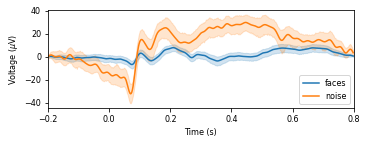

In [296]:
fig, ax = plt.subplots(1, 1, figsize=(4.90, 1.8))
sns.lineplot(data=df, x="index", y="value", hue="condition", ax=ax)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage ($\mu$V)")
ax.set_xlim(tmin, tmax)
ax.legend(loc='lower right')

fig.tight_layout(pad=0)
fig.savefig("ERP-subject602.png", dpi=300)

### Correlations between brain regions

In [297]:
sources = {"fs": read_mat(source_path + 'source_fs_12-0Months_' + subject + '_noise.mat')["sources"],
           "bem": read_mat(source_path + 'source_bem_12-0Months_' + subject + '_noise.mat')["sources"],
           "fem": read_mat(source_path + 'source_fem_12-0Months_' + subject + '_noise.mat')["sources"]}

sources["fem"]["avg"]["pow"] *= 1e12

In [298]:
atlas = "/usr/local/freesurfer/subjects/ANTS12-0Months3T/mri/aparc+aseg.mgz"

epi_img = nib.load(str(atlas))
epi_img_data = epi_img.get_fdata()

vox2ras_tkr = epi_img.header.get_vox2ras_tkr()

pos_atlas = apply_trans(vox2ras_tkr, np.array(np.where(epi_img_data)).T)

kdtree = KDTree(pos_atlas)

In [299]:
no_regions, name_regions = list(zip(*mne.source_space._get_lut()))[:2]

id_model = {}
ts_model = {}
df_model = {}
for model_type in ["fs", "bem", "fem"]:
    dist, points = kdtree.query(sources[model_type]["pos"], 1)
    x, y, z = np.array(np.where(epi_img_data)).T[points].T
    id_model[model_type] = epi_img_data[x, y, z]

    ts_model[model_type] = {}
    for id_ in np.unique(id_model[model_type]):
        region_name = name_region[no_region.index(id_)]
        if "ctx" in region_name:
            region_sources = sources[model_type]["avg"]["pow"][id_ == epi_img_data[x, y, z], int(-tmin*sfreq):]
            ts_model[model_type][id_] = np.nanmean(region_sources, axis=0)   
        
    df_model[model_type] = pd.DataFrame(ts_model[model_type])

In [300]:
dfs = []
for model_type1, model_type2 in zip(["fs", "fs", "fem"], ["fem", "bem", "bem"]):
    id1s = []
    id2s = []
    corr = []
    for id1 in ts_model[model_type1]:
        for id2 in ts_model[model_type2]:
            id1s.append(id1)
            id2s.append(id2)
            corr.append(np.corrcoef([ts_model[model_type1][id1], 
                                     ts_model[model_type2][id2]])[0, 1])

    dfs.append(pd.DataFrame(dict(id1s=id1s, id2s=id2s, corr=corr)))
    dfs[-1]["model1"] = model_type1
    dfs[-1]["model2"] = model_type2 
    dfs[-1]["model12"] = label_dict[model_type1] + "-" + label_dict[model_type2]     
    dfs[-1]["intra"] = dfs[-1]["id1s"] == dfs[-1]["id2s"]

In [301]:
df = pd.concat(dfs)

In [302]:
df.head()

id1s    id2s      corr model1 model2      model12  intra
0  1000.0  1000.0  0.615641     fs    fem  Surface-FEM   True
1  1000.0  1001.0  0.470388     fs    fem  Surface-FEM  False
2  1000.0  1002.0  0.494272     fs    fem  Surface-FEM  False
3  1000.0  1003.0  0.222629     fs    fem  Surface-FEM  False
4  1000.0  1005.0  0.398755     fs    fem  Surface-FEM  False

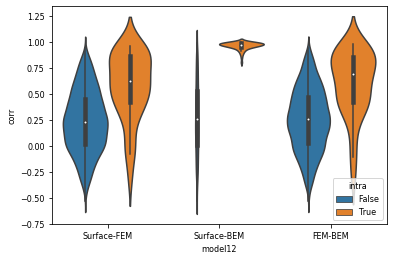

In [303]:
import seaborn as sns
sns.violinplot(y="corr", x="model12", data=df, hue="intra", split=False)

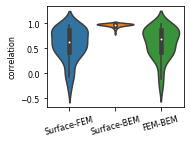

In [304]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 1.8))
sns.violinplot(y="corr", x="model12", scale="width", data=df[df.intra], inner='box', ax=ax)

ax.set_xlabel("")
ax.set_ylabel("correlation")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

fig.tight_layout(pad=0)
fig.savefig("model_corr_violinplot.png", dpi=300)

In [306]:
df[(df.intra) & (df.model12 == "Surface-BEM")].sort_values("corr")

id1s    id2s      corr model1 model2      model12  intra
3781  2022.0  2022.0  0.802018     fs    bem  Surface-BEM   True
70    1001.0  1001.0  0.847445     fs    bem  Surface-BEM   True
2030  1030.0  1030.0  0.877761     fs    bem  Surface-BEM   True
2310  1035.0  1035.0  0.884429     fs    bem  Surface-BEM   True
4131  2027.0  2027.0  0.906270     fs    bem  Surface-BEM   True
...      ...     ...       ...    ...    ...          ...    ...
420   1007.0  1007.0  0.995025     fs    bem  Surface-BEM   True
4341  2030.0  2030.0  0.995974     fs    bem  Surface-BEM   True
3290  2014.0  2014.0  0.997040     fs    bem  Surface-BEM   True
2100  1031.0  1031.0  0.997084     fs    bem  Surface-BEM   True
700   1011.0  1011.0  0.997666     fs    bem  Surface-BEM   True

[66 rows x 7 columns]

### ERP for regions with highest and lowest correlation between the surface and the BEM models

In [78]:
largest_corr = df[(df.intra) & (df.model12 == "Surface-BEM")].sort_values("corr")["id1s"].values[-1] 
smallest_corr = df[(df.intra) & (df.model12 == "Surface-BEM")].sort_values("corr")["id1s"].values[0]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


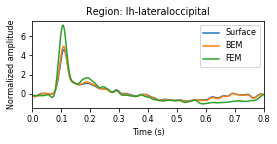

In [307]:
t = np.arange(0, 0.8, 0.002)

fig, ax = plt.subplots(1, 1, figsize=(3.65, 1.8))

label_dict = {"fs": "Surface", "bem": "BEM", "fem": "FEM"}
for model_type in ["fs", "bem", "fem"]:
    ts = ts_model[model_type][largest_corr] / np.mean(ts_model[model_type][largest_corr])
    ts = mne.filter.filter_data(ts, 500.0, l_freq=0.5, h_freq=35.0, verbose=False, method='iir')
    ax.plot(t, ts, label=label_dict[model_type])

ax.legend()
ax.set_xlim(0, 0.8)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized amplitude")

region_name = name_region[no_region.index(int(largest_corr))]
ax.set_title("Region: " + region_name.replace("ctx-", ""));

fig.tight_layout(pad=0)
fig.savefig("ERP_highest_correlations.png", dpi=300)

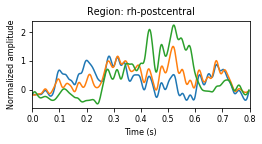

In [309]:
fig, ax = plt.subplots(1, 1, figsize=(3.65, 1.8))

for model_type in ["fs", "bem", "fem"]:
    ts = ts_model[model_type][smallest_corr] / np.mean(ts_model[model_type][smallest_corr])
    ts = mne.filter.filter_data(ts, 500.0, l_freq=0.5, h_freq=35.0, verbose=False, method='iir')
    ax.plot(t, ts, label=label_dict[model_type])

#ax.legend()
ax.set_xlim(0, 0.8)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized amplitude")

region_name = name_region[no_region.index(int(smallest_corr))]
ax.set_title("Region: " + region_name.replace("ctx-", ""));

fig.tight_layout(pad=0)
fig.savefig("ERP_lowest_correlations.png", dpi=300)

### Selecting a time window

In [311]:
stim_type = "noise"
path = source_path + 'tlck_{}_{}.mat'.format(subject, stim_type)
erp  = read_mat(path)
channel_ind = erp["tlck_" + stim_type]["elec"]['label'].index("E75")
erp  = erp["tlck_" + stim_type]["trial"]
erp = mne.filter.filter_data(erp, 500.0, l_freq=0, h_freq=35.0, verbose=False, method='iir')
erp = erp[:, channel_ind, :].mean(0)

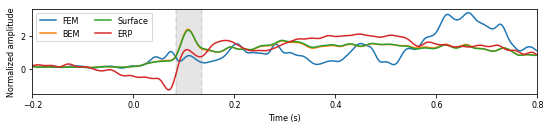

In [318]:
fig, ax = plt.subplots(1, 1, figsize=(7.45, 1.6))

tmin_win = 0.085
tmax_win = 0.135

t=np.arange(tmin, tmax, 1/sfreq)

for model_type in ["fem", "bem", "fs"]:
    ts = np.nanmean(sources[model_type]["avg"]["pow"], 0)/np.nanmean(sources[model_type]["avg"]["pow"])
    ts = mne.filter.filter_data(ts, sfreq, l_freq=0, h_freq=35.0, verbose=False, method='iir')
    plt.plot(t, ts, label=label_dict[model_type])

plt.plot(t, erp/erp.mean(), label="ERP")
plt.legend(ncol=2)
plt.xlim(tmin, tmax)
ymin, ymax = plt.ylim()

plt.xlabel("Time (s)")
plt.ylabel("Normalized amplitude")
plt.axvline(x=tmin_win, linestyle="--", color="k", alpha=0.1)
plt.axvline(x=tmax_win, linestyle="--", color="k", alpha=0.1)
plt.fill_between([tmin_win, tmax_win], [-100, -100], [100, 100], facecolor='k', alpha=0.1)
plt.ylim(ymin, ymax)

fig.tight_layout(pad=0)
plt.savefig("selecting_time_window.png", dpi=300)

### Plotting the topomap

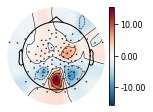

In [347]:
fig, ax = plt.subplots(1, 1, figsize=(2.45, 1.6))

montage = mne.channels.make_standard_montage("GSN-HydroCel-128")

erp = read_mat(source_path + 'tlck_' + subject + '_noise.mat')["tlck_noise"]
inds = (erp["time"] > tmin_win) & (erp["time"] < tmax_win)

plot_values_topomap(dict(zip(erp["label"], erp["trial"].mean(0)[:, inds].mean(1))), 
                    montage, ax, colorbar=True, cmap='RdBu_r', vmin=None, vmax=None)

im = ax.images        
cb = im[-1].colorbar  
cb.ax.tick_params(labelsize=8)

fig.tight_layout()
plt.savefig("topomap.png", dpi=300)

In [339]:
ax.get_yticklabels()

<a list of 0 Text yticklabel objects>

### Source amplitude distribution

In [324]:
mesh_pattern = "/usr/local/freesurfer/subjects/ANTS12-0Months3T/surf/{}.pial"
mesh = trimesh.util.concatenate([trimesh.Trimesh(*read_geometry(mesh_pattern.format(hemi))) 
                                 for hemi in ["lh", "rh"]])


open3d_mesh = open3d.geometry.TriangleMesh(vertices=open3d.utility.Vector3dVector(mesh.vertices),
                                           triangles=open3d.utility.Vector3iVector(mesh.faces))

face_count = 20000
simple = open3d_mesh.simplify_quadric_decimation(int(face_count))

In [325]:
inds = (sources[model_type]["time"] > tmin_win) & (sources[model_type]["time"] < tmax_win)

In [326]:
dfs = []
for model_type in ["bem", "fem", "fs"]:
    inside = sources[model_type]["inside"]
    source_power = np.log10(np.mean(sources[model_type]["avg"]["pow"][inside][:, inds], 1)) # Average across time
    df = pd.DataFrame(source_power)
    df["model"] = label_dict[model_type]    
    dfs.append(df)
df = pd.concat(dfs)

/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/christian/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


-0.43893484599956223 2.0622380682445107 -0.7961302016288532 3.2418345605699983
-1.100099110675567 3.204359126142017 -1.8674283483784981 8.430054085815526
-0.27664791506924763 2.121335266882832 -0.5007608134082465 2.6672835357355513


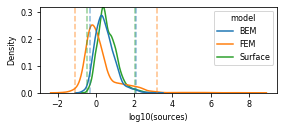

In [331]:
fig, ax = plt.subplots(1, 1, figsize=(3.75, 1.6))

g = sns.kdeplot(data=df, x=df[0], hue="model", hue_order=["BEM", "FEM", "Surface"], ax=ax)
sources_lim_1 = {}
sources_lim_99 = {}
for model_type, line in zip(["bem", "fem", "fs"], g.axes.get_lines()):
    xmin = np.percentile(df[df.model == label_dict[model_type]][0], 1) 
    xmax = np.percentile(df[df.model == label_dict[model_type]][0], 99)   
    
    sources_lim_1[model_type] = xmin
    sources_lim_99[model_type] = xmax
    
    print(xmin, xmax, df[df.model == label_dict[model_type]][0].min(), 
          df[df.model == label_dict[model_type]][0].max())
    ax.axvline(x=xmin, color=line.get_color(), alpha=0.5, linestyle="dashed")
    ax.axvline(x=xmax, color=line.get_color(), alpha=0.5, linestyle="dashed")
    
ax.set_xlabel("log10(sources)")
ax.set_ylim(0, 0.32)

fig.tight_layout(pad=0)
plt.savefig("source_amplitude_distribution.png", dpi=300)

### Plotting sources on meshes

In [176]:
meshes = {}

xmin, xmax = 10**sources_lim_1["fs"], 10**sources_lim_99["fs"] 
for model_type in ["fs", "bem", "fem", "fem2"]:
    
    if model_type == "fem2":
        xmin = np.percentile(source_power, 1) 
        xmax = np.percentile(source_power, 99)  
        model_sources = sources["fem"]
    else:
        model_sources = sources[model_type]
    
    meshes[model_type] = trimesh.Trimesh(vertices=simple.vertices, faces=simple.triangles)
    inside = model_sources["inside"]
    source_kdtree = KDTree(model_sources["pos"][inside, :])

    _, points = source_kdtree.query(meshes[model_type].vertices, 10)
    source_power = np.mean(model_sources["avg"]["pow"][inside][:, inds], 1) # Average across time
    
    if model_type == "fem2":
        xmin = np.percentile(source_power, 1) 
        xmax = np.percentile(source_power, 99)  
    
    norm = mpl.colors.Normalize(vmin=xmin, vmax=xmax)
    cmap = plt.get_cmap("Reds")
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors = m.to_rgba(source_power[points].mean(1))
    colors = np.round(colors*255).astype(np.uint8)
    meshes[model_type].visual.vertex_colors = colors

In [159]:
"""
for model_type in ["fs", "bem", "fem"]:
    scene = trimesh.Scene(geometry=None, base_frame='world', metadata={}, 
                          graph=None, camera=None, lights=None, camera_transform=None)

    test_mesh = meshes[model_type].copy()
    Re = trimesh.transformations.euler_matrix(np.pi/2+0.75, np.pi - 0.25, np.pi/2 + 0.75, 'rxyz')
    test_mesh.apply_transform(Re)
    scene.add_geometry(test_mesh)
    scene.camera.fov = [45, 45]
    scene.show()

    with Path("back_{}.png".format(model_type)).open("wb") as f:
        f.write(scene.save_image([1000, 1000]))    
""";

In [160]:
"""
for model_type in ["fs", "bem", "fem"]:
    scene = trimesh.Scene(geometry=None, base_frame='world', metadata={}, 
                          graph=None, camera=None, lights=None, camera_transform=None)

    test_mesh = meshes[model_type].copy()
    Re = trimesh.transformations.euler_matrix(np.pi/2+0.75, np.pi - 0.25, np.pi + np.pi/2 + 0.75, 'rxyz')
    test_mesh.apply_transform(Re)
    scene.add_geometry(test_mesh)
    scene.camera.fov = [45, 45]
    scene.show()

    from pathlib import Path
    with Path("front_{}.png".format(model_type)).open("wb") as f:
        f.write(scene.save_image([1000, 1000]))
""";

In [240]:
import pyautogui

def show_mesh(model_type, angle_x, angle_y, angle_z):
    scene = trimesh.Scene(geometry=None, base_frame='world', metadata={}, 
                          graph=None, camera=None, lights=None, camera_transform=None)

    test_mesh = meshes[model_type].copy()
    Re = trimesh.transformations.euler_matrix(angle_x, angle_y, angle_z, 'rxyz')
    test_mesh.apply_transform(Re)
    scene.add_geometry(test_mesh)
    scene.camera.fov = [45, 45]
    scene.show()
    return scene   

In [241]:
#angle_x, angle_y, angle_z = np.pi/2+0.75, np.pi - 0.25, np.pi/2 - 0.75
angle_x, angle_y, angle_z = np.pi/2+0.9, np.pi, np.pi + 0.5
scene = show_mesh("bem", angle_x, angle_y, angle_z)
scene.show()

In [242]:
pyautogui.screenshot().save('back_bem.png')

In [243]:
scene = show_mesh("fs", angle_x, angle_y, angle_z)
scene.show()

In [244]:
pyautogui.screenshot().save('back_fs.png')

In [245]:
scene = show_mesh("fem", angle_x, angle_y, angle_z)
scene.show()

In [246]:
pyautogui.screenshot().save('back_fem.png')

In [247]:
angle_x, angle_y, angle_z = np.pi/2+0.75, np.pi - 0.25, np.pi + np.pi/2 + 0.75
scene = show_mesh("fs", angle_x, angle_y, angle_z)
scene.show()

In [248]:
pyautogui.screenshot().save('front_fs.png')

In [249]:
scene = show_mesh("bem", angle_x, angle_y, angle_z)
scene.show()

In [250]:
pyautogui.screenshot().save('front_bem.png')

In [251]:
scene = show_mesh("fem", angle_x, angle_y, angle_z)
scene.show()

In [252]:
pyautogui.screenshot().save('front_fem.png')

In [253]:
angle_x, angle_y, angle_z = np.pi/2- 0.5, np.pi - 0.25, -0.4
scene = show_mesh("fem2", angle_x, angle_y, angle_z)
scene.show()

In [254]:
pyautogui.screenshot().save('fem2.png')